In [1]:
import geopandas as gpd
from shapely.geometry.point import Point
from shapely.geometry import LineString
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from shapely import affinity
from moviepy import editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import math
from matplotlib.patches import Ellipse
%load_ext autoreload
%autoreload 2
sns.set()
%matplotlib inline

In [2]:
from ssalib2 import SpatialSoccer

In [3]:
data = pd.read_csv('positional_data/liverpool_2019.csv')
data['team'].fillna('ball',inplace=True)

# Pass Events


This was a brute force approach I used to identify the pass events in the dataset. [I did this before I realized that Last Row had showed this as well.](https://github.com/Friends-of-Tracking-Data-FoTD/Last-Row/blob/master/notebooks/defining%20possession%20and%20basic%20events.ipynb) My approach was to use a space around the player to detect interaction with the ball. This works, mostly because the data is only for Liverpool attacks.

In [4]:
ball_only = data[data['team']=='ball'].copy()
points = []

for idx,row in ball_only.iterrows():
    point = Point(SpatialSoccer.percent_coordinates_to_statsbomb(row['x'],row['y'],flip_y=False))
    points.append(point)

ball_gdf = gpd.GeoDataFrame(ball_only,geometry=points)
ball_gdf['time'] = ball_gdf['frame']/20
ball_gdf.head()

,Unnamed: 0,bgcolor,dx,dy,edgecolor,frame,play,player,player_num,team,x,y,z,geometry,time
0,0,NaN,0.000000,0.000000,NaN,0,Liverpool [3] - 0 Bournemouth,0,NaN,ball,46.394558,11.134454,0.0,POINT (55.67347 8.90756),0.00
1,1,NaN,0.185745,1.217580,NaN,1,Liverpool [3] - 0 Bournemouth,0,NaN,ball,46.580302,12.352034,0.0,POINT (55.89636 9.88163),0.05
2,2,NaN,0.178659,1.171133,NaN,2,Liverpool [3] - 0 Bournemouth,0,NaN,ball,46.758961,13.523166,0.0,POINT (56.11075 10.81853),0.10
3,3,NaN,0.171573,1.124685,NaN,3,Liverpool [3] - 0 Bournemouth,0,NaN,ball,46.930535,14.647852,0.0,POINT (56.31664 11.71828),0.15
4,4,NaN,0.164488,1.078238,NaN,4,Liverpool [3] - 0 Bournemouth,0,NaN,ball,47.095022,15.726090,0.0,POINT (56.51403 12.58087),0.20


In [5]:
points = []
buffers = []
for idx,row in data[data['team']!='ball'].iterrows():
    point = Point(SpatialSoccer.percent_coordinates_to_statsbomb(row['x'],row['y'],flip_y=False))
    points.append(point)
    buffers.append(point.buffer(1.8))
gdf_all = gpd.GeoDataFrame(data[data['team']!='ball'],geometry=points)
gdf_all["buffer"] = buffers
gdf_all["point"] = points
gdf_all['ballposession'] = np.zeros(len(gdf_all))
gdf_all['time'] = gdf_all['frame']/20

This part identifies if the player was potentially in control or in possession of the ball.

In [6]:
posessions = {}
for play in ball_gdf["play"].unique():
    ball_play = ball_gdf[ball_gdf['play'] == play]
    players_play = gdf_all[gdf_all["play"] == play]
    for indx,row in ball_play.iterrows():
        players_frame = players_play[players_play["frame"]==row["frame"]]
        for jndx,jrow in players_frame.iterrows():
            if jrow['team'] == "attack":
                if jrow["buffer"].intersects(row["geometry"]):
                    posessions["{0}|{1}|{2}".format(play,jrow["frame"],jrow["player"])] = 1
                    break
                elif row["geometry"].x > 120 or row["geometry"].x < 0:
                    posessions["{0}|{1}|{2}".format(play,jrow["frame"],jrow["player"])] = 2
    
    

This places a value for the player if they were in posession of the ball. I use this in the videos to have the player's shirt number print when they are in posession.

In [7]:
for k,v in posessions.items():
    #print(k)
    play,frame,player = k.split("|")
    frame = int(frame)
    player = int(player)
    #print(gdf_all.loc[(gdf_all["play"]==play)&(gdf_all["frame"]==frame)&(gdf_all["player"]==player)])
    gdf_all.loc[(gdf_all["play"]==play)&(gdf_all["frame"]==frame)&(gdf_all["player"]==player),'ballposession'] = v
    #print(gdf_all.loc[(gdf_all["play"]==play)&(gdf_all["frame"]==frame)&(gdf_all["player"]==player)])

# Pass Events

From this informaiton I created an events table that looked for changes in posession between players on the same team. I also tried to identify the shot but that isn't as clean as I would like. I focused on the pass event. This information is then used in the report to create the pass sankey diagrams.

In [11]:
events = {"event_id":[],"play":[],"event_type":[],"start_x":[],"start_y":[],"end_x":[],"end_y":[],"start_frame":[],"end_frame":[],
         "player_start":[],"player_end":[],"player_shirt_start":[],"player_shirt_end":[]}

for play in gdf_all[gdf_all["ballposession"]==1]["play"].unique():
    initevent = None
    prevplayer = None
    play_all = gdf_all[gdf_all["play"] == play]
    start_xy = None
    start_frame = None
    end_xy = None
    prev_xy = None
    player_shirt = None
    for idx,row in play_all.sort_values("frame").iterrows():
        if row['ballposession'] == 1:
            if initevent == None:
                initevent = 1
                prevplayer = row['player']
                start_xy = [row['geometry'].x,row['geometry'].y]
                start_frame = row['frame']
                player_shirt = row['player_num']
            else:
                if prevplayer != row['player']:
                    events["play"].append(play)
                    events["event_id"].append(initevent)
                    events["event_type"].append("pass")
                    events["start_x"].append(start_xy[0])
                    events["start_y"].append(start_xy[1])
                    events["end_x"].append(row['geometry'].x)
                    events["end_y"].append(row['geometry'].y)
                    events["start_frame"].append(start_frame)
                    events["end_frame"].append(row['frame'])
                    events["player_start"].append(prevplayer)
                    events["player_end"].append(row['player'])
                    events["player_shirt_start"].append(player_shirt)
                    events["player_shirt_end"].append(row['player_num'])
                    initevent += 1
                    prevplayer = row['player']
                    start_xy = [row['geometry'].x,row['geometry'].y]
                    start_frame = row['frame']
                    player_shirt = row['player_num']
        elif row['ballposession']==2:
            events["play"].append(play)
            events["event_id"].append(initevent)
            events["event_type"].append("shot")
            events["start_x"].append(start_xy[0])
            events["start_y"].append(start_xy[1])
            events["end_x"].append(row['geometry'].x)
            events["end_y"].append(row['geometry'].y)
            events["start_frame"].append(start_frame)
            events["end_frame"].append(row['frame'])
            events["player_start"].append(prevplayer)
            events["player_end"].append(row['player'])
            events["player_shirt_start"].append(player_shirt)
            events["player_shirt_end"].append(player_shirt)
            break
len(events['event_id'])

73

In [12]:
eventdf = pd.DataFrame(events)
eventdf.head()

,event_id,play,event_type,start_x,start_y,end_x,end_y,start_frame,end_frame,player_start,player_end,player_shirt_start,player_shirt_end
0,1,Liverpool [3] - 0 Bournemouth,pass,55.673469,8.907563,57.439385,21.387032,0,16,471,472,10.0,8.0
1,2,Liverpool [3] - 0 Bournemouth,pass,57.439385,21.387032,84.415309,22.236534,16,67,472,14,8.0,9.0
2,3,Liverpool [3] - 0 Bournemouth,pass,84.415309,22.236534,102.074418,25.017662,67,114,14,331,9.0,11.0
3,4,Liverpool [3] - 0 Bournemouth,shot,102.074418,25.017662,43.591837,10.924370,114,146,331,877,11.0,11.0
4,1,Bayern 0 - [1] Liverpool,pass,39.020408,55.462185,96.524586,59.585146,0,72,670,13,4.0,10.0


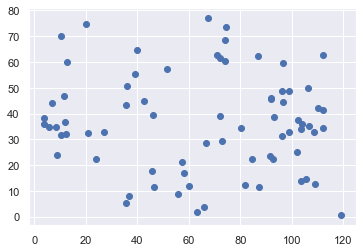

In [13]:
event_geo = [Point(row["start_x"],row["start_y"]) for i,row in eventdf.iterrows()]
eventgdf = gpd.GeoDataFrame(eventdf,geometry=event_geo)
eventgdf.plot();

# Video files

This is the code I used to create my animated goals. You can change the dpi, and figure size to make better quality videos.


In [11]:
def draw_frame_x(df, ball, t, title=None):
    fig = plt.figure(figsize = (5,3),dpi=140)
    ax = fig.add_subplot(111)
    if title:
        ax.set_title(title)
    ax.set_xlim([-1,121])
    ax.set_ylim([-1,81])
    pitchgdf = SpatialSoccer.build_polygon_pitch_statsbomb()
    pitchgdf.plot(ax = ax, facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
    frm = int(t*20)
    ball[(ball['frame']==frm)].plot(ax=ax,zorder=3,facecolor='white',hatch=2*'O',markersize=70);
    df[(df['frame']==frm) &(df['team']=='attack')].plot(ax=ax,color="red",edgecolor="white", markersize=70);
    #df[(df['frame']==frm) &(df['team']=='attack') &(df['ballposession']==1)].plot(ax=ax,color="white",marker="x",zorder=4);
    #df[(df['frame']==frm) &(df['team']=='attack') &(df['ballposession']==2)].plot(ax=ax,color="white",marker="^",zorder=4);
    df[(df['frame']==frm) &(df['team']=='defense')].plot(ax=ax,color="yellow",edgecolor="white",markersize=70);
    #for idx, row in df[(df['time']==t) &(df['team']=='attack')].iterrows():
    for idx, row in df[(df['frame']==frm) &(df['team']=='attack') &(df['ballposession']==1)].iterrows():
        try:
            ax.text(row['geometry'].x,row['geometry'].y,int(row['player_num']),color='white',fontsize=12,zorder=5)
        except:
            pass
            #ax.text(row['geometry'].x,row['geometry'].y,'NAN')
    
    image = mplfig_to_npimage(fig)
    plt.close()
    del pitchgdf
    return image    

def make_animation_gdf(gdf,ball,title=None):
    #return gdf
    length=(gdf.frame.max()+20)/20
    clip = mpy.VideoClip(lambda x: draw_frame_x(gdf, ball, t=x,title=title), duration=length-1).set_fps(20)
    return clip


In [ ]:
for play in gdf_all["play"].unique():
    if play == 'Liverpool [2] - 0 Everton':
        df_current = gdf_all[gdf_all['play']==play].copy()
        clip = make_animation_gdf(df_current,ball_gdf[ball_gdf['play']==play],play)

        clip.ipython_display()
        #if you want an mp4 then uncomment the line below this, and increase the size of the figure.
        #clip.write_videofile("liverpool_goals/posession_{0}.mp4".format(play))
        clip.write_gif("liverpool_goals/posession_{0}.gif".format(play),fps=20)
        del df_current

# Pitch Control Probabilities

For every pass event in the dataset, I calcualted which team controlled the end position of the ball preceding the pass. This is derived from the pass control and velocities code taken from FoT tutorial on pass control: [https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking)

I slightly modified the code to fit within my toolset.


In [10]:
eventgdf['attackprob'] = np.zeros(len(eventgdf))
eventgdf['defenseprob'] = np.zeros(len(eventgdf))
aprob = []
dprob = []

for idx,row in eventgdf.iterrows():
    if row['event_type'] == "pass":
        gdf = gdf_all[gdf_all['play']==row['play']].copy()
        ball_point = Point(row.start_x,row.start_y)
        target_point = Point(row.end_x,row.end_y)
        player_id_field = "player"
        point_field = "geometry"
        time_field = "time"
        maxspeed = 12
        smooth = True
        window = 7
        #calculate the individual velocities
        SpatialSoccer.player_velocities(gdf,player_id_field,point_field,time_field)

        gdff = gdf[gdf['frame'] == row.start_frame].copy()
        attackdf = gdff[gdff['team']=='attack'][['geometry','time','velocity']].copy()
        defensedf = gdff[gdff['team']=='defense'][['geometry','time','velocity']].copy()
        #in my pitch control function it expects individual level reaction times. these are set in a column
        attackdf['reaction'] = .7
        defensedf['reaction'] = .7
        #I decided to use mean velocity if the mean was negative for some reason then a default of 5 was used.
        if attackdf['velocity'].mean() <= 0:
            attackdf['velocity'] = 5
        else:
            attackdf['velocity'] = attackdf['velocity'].mean()

        if defensedf['velocity'].mean() <= 0:
            defensedf['velocity'] = 5
        else:
            defensedf['velocity'] = defensedf['velocity'].mean()

        a,d = SpatialSoccer.pitch_control_at_target(target_point,ball_point,attackdf,defensedf,"geometry", "velocity", "reaction", ball_velocity=15)
        aprob.append(a)
        dprob.append(d)
    else:
        #this is for the shots, I was only interested in passes.
        aprob.append(np.nan)
        dprob.append(np.nan)

NameError: name 'eventgdf' is not defined

In [ ]:
eventgdf['attackprob'] = aprob
eventgdf['defenseprob'] = dprob

#This file is used in the report:
#eventgdf.to_csv("liverpool_pass_events_probability.csv",index=False)

### Pitch control for the Goal against everton

In [ ]:
pass_i = 1
#grid used for the pitch. You can decrease the number to create a finer resolution of pitch control. Or use the interpolation techniques shown in the FoT vidoe.
griddf = SpatialSoccer.build_grid(5)
for idx,row in eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iterrows():
    if row['event_type'] == "pass":
        gdf = gdf_all[gdf_all['play']==row['play']].copy()
        ball_point = Point(row.start_x,row.start_y)
        
        player_id_field = "player"
        point_field = "geometry"
        time_field = "time"
        maxspeed = 12
        smooth = True
        window = 7
        #calculate the individual velocities
        SpatialSoccer.player_velocities(gdf,player_id_field,point_field,time_field)

        gdff = gdf[gdf['frame'] == row.start_frame].copy()
        attackdf = gdff[gdff['team']=='attack'][['geometry','time','velocity']].copy()
        defensedf = gdff[gdff['team']=='defense'][['geometry','time','velocity']].copy()
        attackdf['reaction'] = .7
        defensedf['reaction'] = .7

        if attackdf['velocity'].mean() <= 0:
            attackdf['velocity'] = 5
        else:
            attackdf['velocity'] = attackdf['velocity'].mean()

        if defensedf['velocity'].mean() <= 0:
            defensedf['velocity'] = 5
        else:
            defensedf['velocity'] = defensedf['velocity'].mean()
        
        defenseprob = []
        attackprob = []
        #iterate over the grid
        for indx,row in griddf.iterrows():
            target_point = row['centroid']
            a,d = SpatialSoccer.pitch_control_at_target(target_point,ball_point,attackdf,defensedf,"geometry", "velocity", "reaction", ball_velocity=15)
            attackprob.append(a)
            defenseprob.append(d)
        nma = "aprob_{0}".format(pass_i)
        nmd = "dprob_{0}".format(pass_i)
        griddf[nma] = attackprob
        griddf[nmd] = defenseprob
        pass_i +=1
        print(pass_i)

In [ ]:

from mpl_toolkits.axes_grid1 import make_axes_locatable
gdf = gdf_all[gdf_all['play']=='Liverpool [2] - 0 Everton'].copy()
SpatialSoccer.player_velocities(gdf,"player","geometry","time")
gdff = gdf[gdf['frame'] == 30].copy()
pitchgdf = SpatialSoccer.build_polygon_pitch_statsbomb()


fig = plt.figure(figsize = (10,6),dpi=300)
ax = fig.add_subplot(111)
pitchgdf.plot(ax=ax,facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
griddf.plot(ax=ax, column="dprob_2",alpha=.5,cmap="Reds_r",edgecolor="none",legend=True,legend_kwds={'label': "Defense Control",
            'orientation': "horizontal"},cax=cax)


ax.scatter(eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].start_x,
           eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].start_y,
           facecolor='white',hatch=2*'O',s=120,label="Start")
ax.scatter(eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].end_x,eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].end_y,
          facecolor='white',marker='^',s=120,label="End");
ax.legend(loc="lower right")
gdff[gdff['team']=='attack'].plot(ax=ax,color="red",zorder=3,edgecolor="white", markersize=70)
gdff[gdff['team']=='defense'].plot(ax=ax,color="yellow",zorder=3,edgecolor="white", markersize=70);
#plt.savefig("everton_pitchcontrol_2ndpass.png",dpi=300)

# Potential Path Areas

Potential Path Areas are a ellipitical representation of the areas an entity or moving object could travel to given an amount of time, velocity, and destination point. They tend to be used to understand where something was (potentially) between two different known locations. 

Here I'm using them as a naive pitch control to demonstrate which players could be in reach of the ball at its end destination. 

I used a velocity of 6, but you can play around with this number to see how it puts players in reach of the ball. You can also use a different centering point for the ellipse

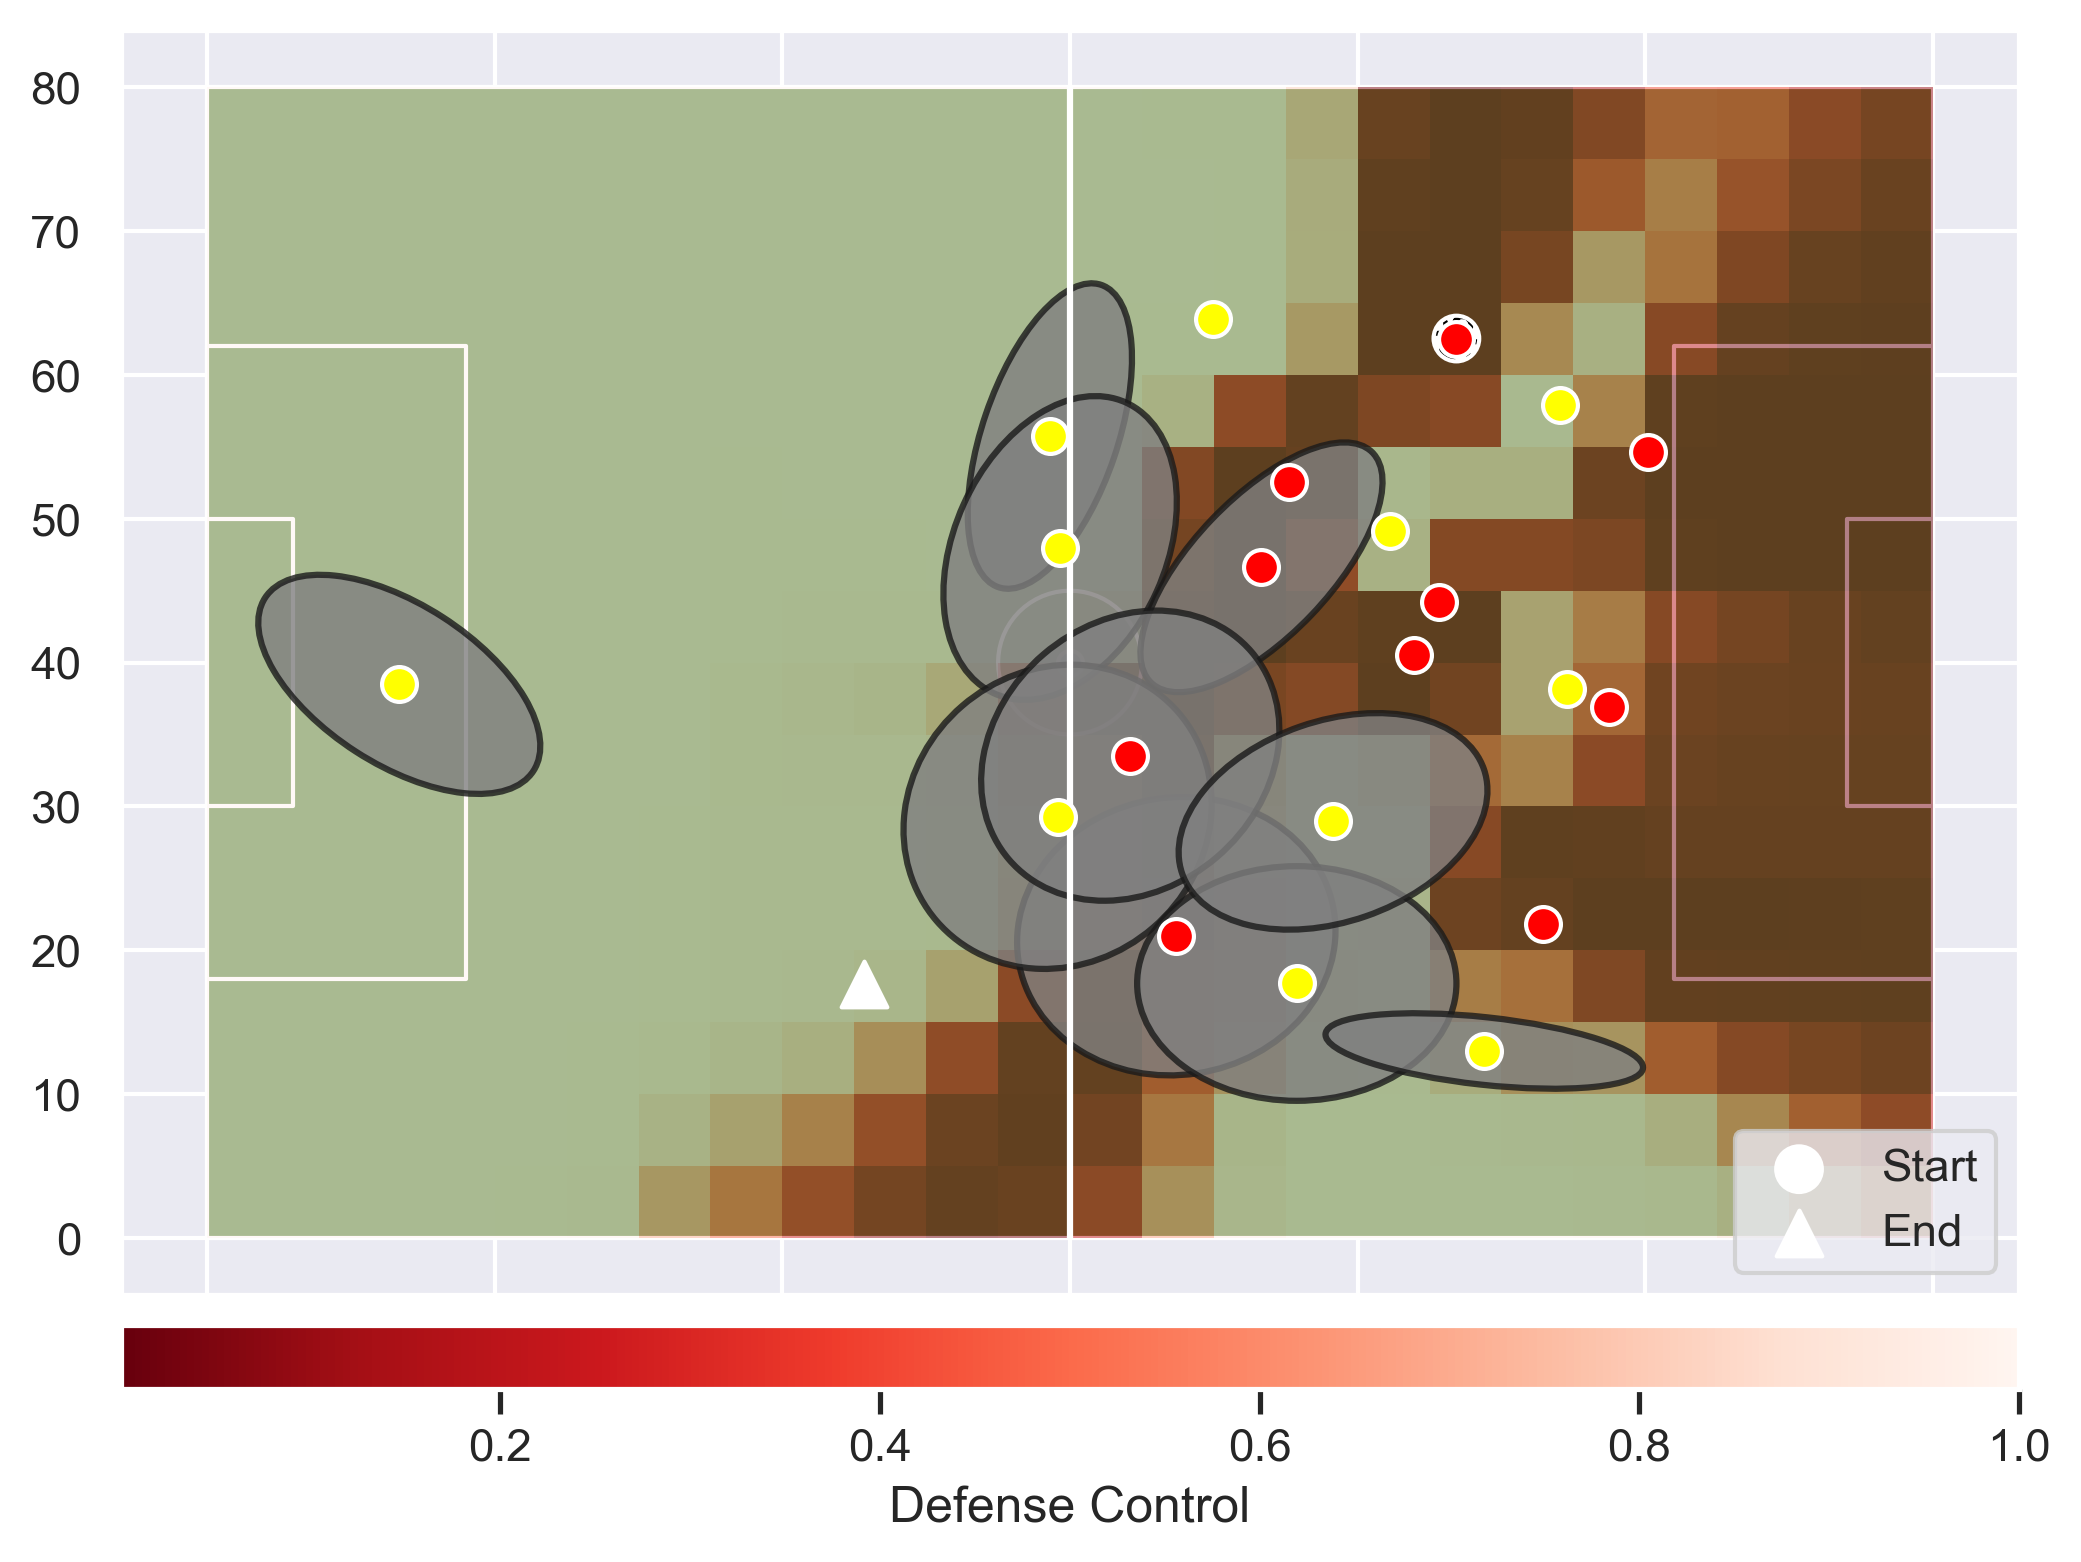

In [22]:
import math
from matplotlib.patches import Ellipse
def ppa(startPnt,endPnt,average_duration_start, velocity):
    ls = LineString([startPnt,endPnt])
    mp = ls.interpolate(0.5, normalized = True)
    dx = startPnt.x - endPnt.x
    dy = startPnt.y - endPnt.y
    angle =math.degrees(math.atan2(dy,dx))

    a = average_duration_start*velocity

    c = ls.length /2.0

    b = math.sqrt((a**2)-(c**2))

    #cp = Ellipse(xy=(mp.x,mp.y), width=a, height=b,angle=angle,facecolor="grey",alpha=.8,ec='k',lw=1.5)
    cp = Ellipse(xy=(startPnt.x,startPnt.y), width=a, height=b,angle=angle,facecolor="grey",alpha=.8,ec='k',lw=1.5)
    return cp
average_duration_start = (eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1]['end_frame']/20) - (eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1]['start_frame']/20)
fig = plt.figure(figsize = (10,6),dpi=300)
ax = fig.add_subplot(111)
pitchgdf.plot(ax=ax,facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
griddf.plot(ax=ax, column="dprob_2",alpha=.5,cmap="Reds_r",edgecolor="none",legend=True,legend_kwds={'label': "Defense Control",
            'orientation': "horizontal"},cax=cax)


ax.scatter(eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].start_x,
           eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].start_y,
           facecolor='white',hatch=2*'O',s=120,label="Start")
ax.scatter(eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].end_x,eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].end_y,
          facecolor='white',marker='^',s=120,label="End");
ax.legend(loc="lower right")
endpnt = Point(eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].end_x,eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].end_y)
for idx,row in gdff.iterrows():
    try:
        cp = ppa(row['point'],endpnt,average_duration_start,6)
        ax.add_patch(cp)
    except:
        pass
gdff[gdff['team']=='attack'].plot(ax=ax,color="red",zorder=3,edgecolor="white", markersize=70)
gdff[gdff['team']=='defense'].plot(ax=ax,color="yellow",zorder=3,edgecolor="white", markersize=70);
#plt.savefig("everton_pitchcontrol_2ndpass_ellipse.png",dpi=300)

For example if I put it at the midpoint between the player's current location and the future location of the ball, one player could reach the ball in the time it took at a velocity of 5 meters per second. It's the everton player. That means liverpool had to come from behind to reach the ball.

Even more interesting is that it wasn't the Liverpool player that was theoretically the closest at the start of the pass that was the one that reached it first.

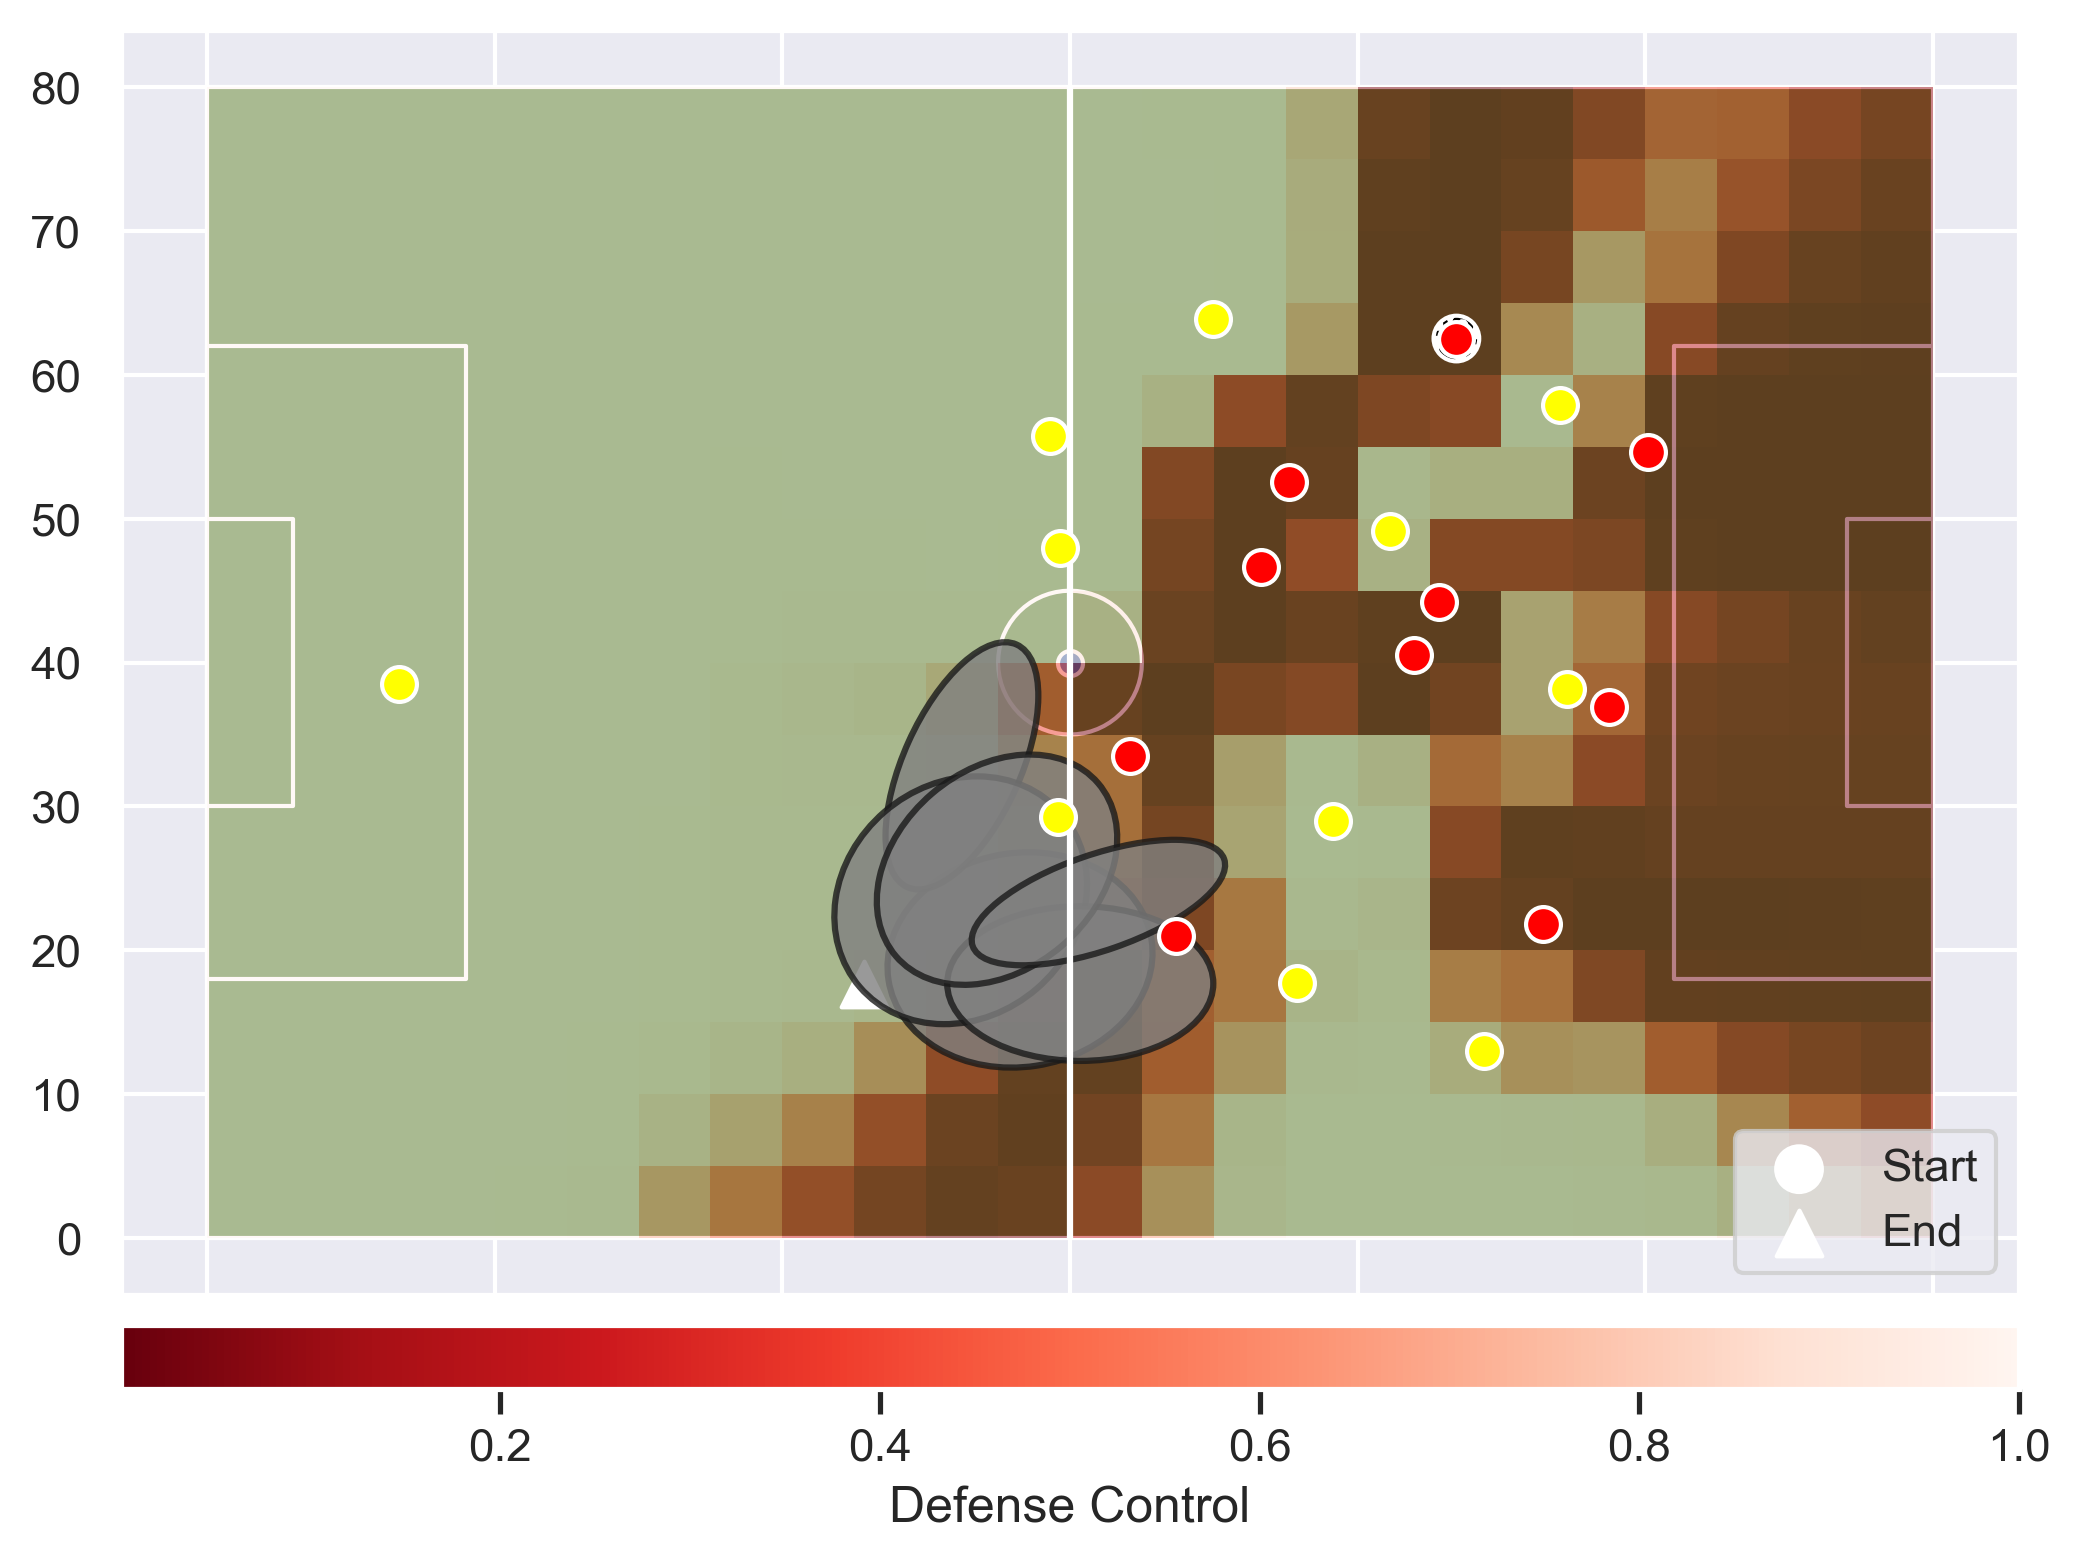

In [24]:

def ppa(startPnt,endPnt,average_duration_start, velocity):
    ls = LineString([startPnt,endPnt])
    mp = ls.interpolate(0.5, normalized = True)
    dx = startPnt.x - endPnt.x
    dy = startPnt.y - endPnt.y
    angle =math.degrees(math.atan2(dy,dx))

    a = average_duration_start*velocity

    c = ls.length /2.0

    b = math.sqrt((a**2)-(c**2))

    cp = Ellipse(xy=(mp.x,mp.y), width=a, height=b,angle=angle,facecolor="grey",alpha=.8,ec='k',lw=1.5)
    #cp = Ellipse(xy=(startPnt.x,startPnt.y), width=a, height=b,angle=angle,facecolor="grey",alpha=.8,ec='k',lw=1.5)
    return cp
average_duration_start = (eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1]['end_frame']/20) - (eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1]['start_frame']/20)
fig = plt.figure(figsize = (10,6),dpi=300)
ax = fig.add_subplot(111)
pitchgdf.plot(ax=ax,facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
griddf.plot(ax=ax, column="dprob_2",alpha=.5,cmap="Reds_r",edgecolor="none",legend=True,legend_kwds={'label': "Defense Control",
            'orientation': "horizontal"},cax=cax)


ax.scatter(eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].start_x,
           eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].start_y,
           facecolor='white',hatch=2*'O',s=120,label="Start")
ax.scatter(eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].end_x,eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].end_y,
          facecolor='white',marker='^',s=120,label="End");
ax.legend(loc="lower right")
endpnt = Point(eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].end_x,eventgdf[eventgdf['play']=='Liverpool [2] - 0 Everton'].iloc[1].end_y)
for idx,row in gdff.iterrows():
    try:
        cp = ppa(row['point'],endpnt,average_duration_start,5)
        ax.add_patch(cp)
    except:
        pass
gdff[gdff['team']=='attack'].plot(ax=ax,color="red",zorder=3,edgecolor="white", markersize=70)
gdff[gdff['team']=='defense'].plot(ax=ax,color="yellow",zorder=3,edgecolor="white", markersize=70);
#plt.savefig("everton_pitchcontrol_2ndpass_ellipse.png",dpi=300)

# Animated PPA



In [ ]:


def ppa(startPnt,endPnt,average_duration_start, velocity):
    ls = LineString([startPnt,endPnt])
    mp = ls.interpolate(0.5, normalized = True)
    dx = startPnt.x - endPnt.x
    dy = startPnt.y - endPnt.y
    angle =math.degrees(math.atan2(dy,dx))

    a = average_duration_start*velocity

    c = ls.length /2.0

    b = math.sqrt((a**2)-(c**2))

    #cp = Ellipse(xy=(mp.x,mp.y), width=a, height=b,angle=angle,facecolor="grey",alpha=.8,ec='k',lw=1.5)
    cp = Ellipse(xy=(startPnt.x,startPnt.y), width=a, height=b,angle=angle,facecolor="grey",alpha=.8,ec='k',lw=1.5)
    return cp

def draw_frame_x(df, ball, t, title=None):
    fig = plt.figure(figsize = (5,3),dpi=130)
    ax = fig.add_subplot(111)
    if title:
        ax.set_title(title)
    ax.set_xlim([-1,121])
    ax.set_ylim([-1,81])
    pitchgdf = SpatialSoccer.build_polygon_pitch_statsbomb()
    pitchgdf.plot(ax = ax, facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
    frm = int(t*20)
    ball[(ball['frame']==frm)].plot(ax=ax,zorder=3,facecolor='white',hatch=2*'O',markersize=70);
    df[(df['frame']==frm) &(df['team']=='attack')].plot(ax=ax,color="red",edgecolor="white", markersize=70);
    #df[(df['frame']==frm) &(df['team']=='attack') &(df['ballposession']==1)].plot(ax=ax,color="white",marker="x",zorder=4);
    #df[(df['frame']==frm) &(df['team']=='attack') &(df['ballposession']==2)].plot(ax=ax,color="white",marker="^",zorder=4);
    df[(df['frame']==frm) &(df['team']=='defense')].plot(ax=ax,color="yellow",edgecolor="white",markersize=70);
    #for idx, row in df[(df['time']==t) &(df['team']=='attack')].iterrows():
    for idx, row in df[(df['frame']==frm) &(df['team']=='attack') &(df['ballposession']==2)].iterrows():
        try:
            ax.text(row['geometry'].x,row['geometry'].y,int(row['player_num']),color='white',fontsize=12,zorder=5)
        except:
            pass
            #ax.text(row['geometry'].x,row['geometry'].y,'NAN')
    for idx, row in df[(df['frame']==frm)].iterrows():
        try:
            cp = ppa(row['geometry'],ball[(ball['frame']==frm)]['geometry'].values[0],1,row['velocity'])
            if row['team'] == 'attack':
                cp.set_facecolor("red")
            else:
                cp.set_facecolor("yellow")
            ax.add_patch(cp)
        except:
            pass
    image = mplfig_to_npimage(fig)
    plt.close()
    del pitchgdf
    return image    

def make_animation_gdf(gdf,ball,title=None):
    #return gdf
    length=(gdf.frame.max()+20)/20
    clip = mpy.VideoClip(lambda x: draw_frame_x(gdf, ball, t=x,title=title), duration=length-1).set_fps(20)
    return clip


for play in gdf_all["play"].unique():
    if play == 'Liverpool [2] - 0 Everton':
        df_current = gdf_all[gdf_all['play']==play].copy()
        SpatialSoccer.player_velocities(df_current,"player","geometry","time")
        #draw_frame_x(df_current,ball_gdf[ball_gdf['play']==play],t=1)
        clip = make_animation_gdf(df_current,ball_gdf[ball_gdf['play']==play],play)

        #clip.ipython_display()
        #if you want an mp4 then uncomment the line below this, and increase the size of the figure.
        #clip.write_videofile("liverpool_goals/ppa_mp_{0}.mp4".format(play))
        clip.write_gif("liverpool_goals/posession_{0}.gif".format(play),fps=20)
        del df_current

t:   0%|                                                                             | 0/286 [00:00<?, ?it/s, now=None]

MoviePy - Building file liverpool_goals/posession_Liverpool [2] - 0 Everton.gif with imageio.


t:  87%|██████████████████████████████████████████████████████████▌        | 250/286 [01:16<00:10,  3.39it/s, now=None]